<a href="https://colab.research.google.com/github/tom-brash/handson-ml2/blob/master/workbooks/cha8/breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Managing critical installations required to display breakout

In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay

In [ ]:
!pip install tf-agents

In [ ]:
!pip install --upgrade 'gym[atari]'

### Importing key and common libraries

In [1]:
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tf_agents.environments import suite_gym
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

### Setting up virtual environment

Function defined to show observations across four color channels

In [2]:
environment_name = 'BreakoutNoFrameskip-v4'
max_episode_steps = 27000

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4]
)

env

In [3]:
env.seed(42)
env.reset()
time_step = env.step(np.array(1))
for _ in range(4):
  time_step = env.step(np.array(3))

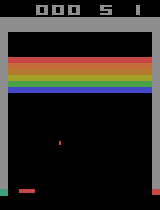

In [4]:
PIL.Image.fromarray(env.render())

In [5]:
def plot_observation(obs):
  obs = obs.astype(np.float32)
  img = obs[..., :3]
  current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
  img[..., 0] += current_frame_delta
  img[..., 2] += current_frame_delta
  img = np.clip(img / 150, 0, 1)
  plt.imshow(img)
  plt.axis('off')

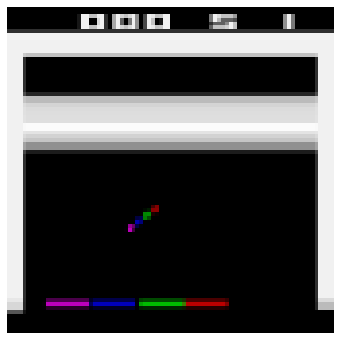

In [6]:
plt.figure(figsize=(6,6))
plot_observation(time_step.observation)
plt.show()

In [7]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment
tf_env = TFPyEnvironment(env)

## Creating the Deep Q-Network (DQN)

In [8]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.)

conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params = [512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)

In [9]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, 
                                     decay=0.95, 
                                     momentum=0.0, 
                                     epsilon=0.00001, centered=True)

epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)


agent = DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction='none'),
    gamma=0.99,
    train_step_counter=train_step,
    epsilon_greedy=lambda: epsilon_fn(train_step)
)

agent.initialize()


In [29]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=300000)


replay_buffer_observer = replay_buffer.add_batch

In [30]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [55]:
from tf_agents.metrics import tf_metrics

train_metrics = [
                 tf_metrics.NumberOfEpisodes(),
                 tf_metrics.EnvironmentSteps(),
                 tf_metrics.AverageReturnMetric(),
                 tf_metrics.AverageEpisodeLengthMetric()
]

In [56]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period)


In [33]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000)

final_time_step, final_policy_state = init_driver.run()

20000/20000

In [34]:
trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3
)

In [35]:
trajectories._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [36]:
trajectories.observation.shape

TensorShape([2, 3, 84, 84, 4])

In [37]:
trajectories.step_type.numpy()

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [38]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

TensorShape([2, 2, 84, 84, 4])

In [39]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3
).prefetch(3)

In [51]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [52]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)


In [57]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [111]:
train_agent(n_iterations=100000)

INFO:absl: 
		 NumberOfEpisodes = 892
		 EnvironmentSteps = 201808
		 AverageReturn = 9.199999809265137
		 AverageEpisodeLength = 365.6000061035156


999 loss:0.00773

INFO:absl: 
		 NumberOfEpisodes = 903
		 EnvironmentSteps = 205808
		 AverageReturn = 9.600000381469727
		 AverageEpisodeLength = 367.0


1998 loss:0.00797

INFO:absl: 
		 NumberOfEpisodes = 913
		 EnvironmentSteps = 209808
		 AverageReturn = 9.300000190734863
		 AverageEpisodeLength = 404.6000061035156


2998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 923
		 EnvironmentSteps = 213808
		 AverageReturn = 9.100000381469727
		 AverageEpisodeLength = 375.8999938964844


3998 loss:0.00782

INFO:absl: 
		 NumberOfEpisodes = 933
		 EnvironmentSteps = 217808
		 AverageReturn = 10.100000381469727
		 AverageEpisodeLength = 395.0


4998 loss:0.01594

INFO:absl: 
		 NumberOfEpisodes = 942
		 EnvironmentSteps = 221808
		 AverageReturn = 10.199999809265137
		 AverageEpisodeLength = 440.5


5998 loss:0.00788

INFO:absl: 
		 NumberOfEpisodes = 951
		 EnvironmentSteps = 225808
		 AverageReturn = 10.300000190734863
		 AverageEpisodeLength = 437.79998779296875


6998 loss:0.00760

INFO:absl: 
		 NumberOfEpisodes = 960
		 EnvironmentSteps = 229808
		 AverageReturn = 10.399999618530273
		 AverageEpisodeLength = 486.5


7998 loss:0.05294

INFO:absl: 
		 NumberOfEpisodes = 967
		 EnvironmentSteps = 233808
		 AverageReturn = 10.399999618530273
		 AverageEpisodeLength = 517.2999877929688


8998 loss:0.00766

INFO:absl: 
		 NumberOfEpisodes = 974
		 EnvironmentSteps = 237808
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 557.2000122070312


9998 loss:0.00779

INFO:absl: 
		 NumberOfEpisodes = 981
		 EnvironmentSteps = 241808
		 AverageReturn = 10.0
		 AverageEpisodeLength = 553.0999755859375


10998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 985
		 EnvironmentSteps = 245808
		 AverageReturn = 10.300000190734863
		 AverageEpisodeLength = 698.0999755859375


11998 loss:0.00785

INFO:absl: 
		 NumberOfEpisodes = 988
		 EnvironmentSteps = 249808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 937.4000244140625


12998 loss:0.01580

INFO:absl: 
		 NumberOfEpisodes = 990
		 EnvironmentSteps = 253808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1225.5999755859375


13998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 991
		 EnvironmentSteps = 257808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1313.5999755859375


14998 loss:0.01562

INFO:absl: 
		 NumberOfEpisodes = 994
		 EnvironmentSteps = 261808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1768.0999755859375


15998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 995
		 EnvironmentSteps = 265808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1968.9000244140625


16998 loss:0.00803

INFO:absl: 
		 NumberOfEpisodes = 997
		 EnvironmentSteps = 269808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2032.0999755859375


17998 loss:0.00808

INFO:absl: 
		 NumberOfEpisodes = 999
		 EnvironmentSteps = 273808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2119.60009765625


18998 loss:0.00825

INFO:absl: 
		 NumberOfEpisodes = 1001
		 EnvironmentSteps = 277808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2253.699951171875


19998 loss:0.00811

INFO:absl: 
		 NumberOfEpisodes = 1003
		 EnvironmentSteps = 281808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1935.4000244140625


20998 loss:0.00812

INFO:absl: 
		 NumberOfEpisodes = 1005
		 EnvironmentSteps = 285808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1992.4000244140625


21998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1008
		 EnvironmentSteps = 289808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1835.0


22998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1009
		 EnvironmentSteps = 293808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1952.4000244140625


23998 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 1011
		 EnvironmentSteps = 297808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1981.9000244140625


24998 loss:0.00779

INFO:absl: 
		 NumberOfEpisodes = 1013
		 EnvironmentSteps = 301808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2167.60009765625


25998 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 1015
		 EnvironmentSteps = 305808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2095.800048828125


26998 loss:0.06314

INFO:absl: 
		 NumberOfEpisodes = 1016
		 EnvironmentSteps = 309808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2300.800048828125


27998 loss:0.05466

INFO:absl: 
		 NumberOfEpisodes = 1017
		 EnvironmentSteps = 313808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2336.60009765625


28998 loss:0.05464

INFO:absl: 
		 NumberOfEpisodes = 1020
		 EnvironmentSteps = 317808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2060.300048828125


29998 loss:0.00008

INFO:absl: 
		 NumberOfEpisodes = 1022
		 EnvironmentSteps = 321808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2246.10009765625


30998 loss:0.00762

INFO:absl: 
		 NumberOfEpisodes = 1024
		 EnvironmentSteps = 325808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2110.0


31998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1025
		 EnvironmentSteps = 329808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2110.300048828125


32998 loss:0.01568

INFO:absl: 
		 NumberOfEpisodes = 1028
		 EnvironmentSteps = 333808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1955.800048828125


33998 loss:0.01604

INFO:absl: 
		 NumberOfEpisodes = 1029
		 EnvironmentSteps = 337808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1928.0


34998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1031
		 EnvironmentSteps = 341808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2099.89990234375


35998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1032
		 EnvironmentSteps = 345808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2309.0


36998 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 1034
		 EnvironmentSteps = 349808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2253.10009765625


37998 loss:0.00776

INFO:absl: 
		 NumberOfEpisodes = 1036
		 EnvironmentSteps = 353808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2189.0


38998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1037
		 EnvironmentSteps = 357808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2149.60009765625


39998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1038
		 EnvironmentSteps = 361808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2496.699951171875


40998 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 1040
		 EnvironmentSteps = 365808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2734.0


41998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1041
		 EnvironmentSteps = 369808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2878.10009765625


42998 loss:0.05463

INFO:absl: 
		 NumberOfEpisodes = 1042
		 EnvironmentSteps = 373808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2594.0


43998 loss:0.00775

INFO:absl: 
		 NumberOfEpisodes = 1044
		 EnvironmentSteps = 377808
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 2768.10009765625


44998 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 1046
		 EnvironmentSteps = 381808
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 2824.0


45998 loss:0.00832

INFO:absl: 
		 NumberOfEpisodes = 1048
		 EnvironmentSteps = 385808
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 2722.300048828125


46998 loss:0.00765

INFO:absl: 
		 NumberOfEpisodes = 1049
		 EnvironmentSteps = 389808
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 2454.89990234375


47998 loss:0.05480

INFO:absl: 
		 NumberOfEpisodes = 1050
		 EnvironmentSteps = 393808
		 AverageReturn = 10.699999809265137
		 AverageEpisodeLength = 2495.199951171875


48998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1053
		 EnvironmentSteps = 397808
		 AverageReturn = 10.300000190734863
		 AverageEpisodeLength = 2321.800048828125


49998 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 1053
		 EnvironmentSteps = 401808
		 AverageReturn = 10.300000190734863
		 AverageEpisodeLength = 2321.800048828125


50998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1055
		 EnvironmentSteps = 405808
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 2653.39990234375


51998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1056
		 EnvironmentSteps = 409808
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 2573.699951171875


52998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1058
		 EnvironmentSteps = 413808
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 2693.300048828125


53998 loss:0.00784

INFO:absl: 
		 NumberOfEpisodes = 1059
		 EnvironmentSteps = 417808
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 2764.89990234375


54998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1061
		 EnvironmentSteps = 421808
		 AverageReturn = 10.600000381469727
		 AverageEpisodeLength = 2646.300048828125


55998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1062
		 EnvironmentSteps = 425808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2775.699951171875


56998 loss:0.00772

INFO:absl: 
		 NumberOfEpisodes = 1064
		 EnvironmentSteps = 429808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2622.5


57998 loss:0.05469

INFO:absl: 
		 NumberOfEpisodes = 1064
		 EnvironmentSteps = 433808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2622.5


58998 loss:0.00006

INFO:absl: 
		 NumberOfEpisodes = 1066
		 EnvironmentSteps = 437808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2987.800048828125


59998 loss:0.10939

INFO:absl: 
		 NumberOfEpisodes = 1067
		 EnvironmentSteps = 441808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 3007.800048828125


60998 loss:0.00007

INFO:absl: 
		 NumberOfEpisodes = 1069
		 EnvironmentSteps = 445808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2954.699951171875


61998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 1070
		 EnvironmentSteps = 449808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2926.699951171875


62998 loss:0.05477

INFO:absl: 
		 NumberOfEpisodes = 1073
		 EnvironmentSteps = 453808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2653.300048828125


63998 loss:0.00795

INFO:absl: 
		 NumberOfEpisodes = 1074
		 EnvironmentSteps = 457808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2594.89990234375


64998 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1076
		 EnvironmentSteps = 461808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2453.39990234375


65998 loss:0.00781

INFO:absl: 
		 NumberOfEpisodes = 1077
		 EnvironmentSteps = 465808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2220.89990234375


66998 loss:0.01539

INFO:absl: 
		 NumberOfEpisodes = 1079
		 EnvironmentSteps = 469808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2246.699951171875


67998 loss:0.00789

INFO:absl: 
		 NumberOfEpisodes = 1081
		 EnvironmentSteps = 473808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2283.0


68998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 1082
		 EnvironmentSteps = 477808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2468.0


69998 loss:0.00771

INFO:absl: 
		 NumberOfEpisodes = 1082
		 EnvironmentSteps = 481808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2468.0


70998 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 1085
		 EnvironmentSteps = 485808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2578.699951171875


71998 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1087
		 EnvironmentSteps = 489808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2516.10009765625


72998 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1089
		 EnvironmentSteps = 493808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2564.699951171875


73998 loss:0.00011

INFO:absl: 
		 NumberOfEpisodes = 1091
		 EnvironmentSteps = 497808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2420.89990234375


74998 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1093
		 EnvironmentSteps = 501808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1955.0


75998 loss:0.00010

INFO:absl: 
		 NumberOfEpisodes = 1096
		 EnvironmentSteps = 505808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1831.699951171875


76998 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1098
		 EnvironmentSteps = 509808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1799.199951171875


77998 loss:0.00001

INFO:absl: 
		 NumberOfEpisodes = 1100
		 EnvironmentSteps = 513808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1911.300048828125


78998 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1101
		 EnvironmentSteps = 517808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1766.199951171875


79998 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1104
		 EnvironmentSteps = 521808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1774.300048828125


80998 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 1106
		 EnvironmentSteps = 525808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2050.10009765625


81998 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1107
		 EnvironmentSteps = 529808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2022.9000244140625


82998 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1109
		 EnvironmentSteps = 533808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2221.699951171875


83999 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1112
		 EnvironmentSteps = 537808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1956.800048828125


84999 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1113
		 EnvironmentSteps = 541808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2037.5


85999 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1114
		 EnvironmentSteps = 545808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2173.800048828125


86999 loss:0.00004

INFO:absl: 
		 NumberOfEpisodes = 1117
		 EnvironmentSteps = 549808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2235.199951171875


87999 loss:0.00772

INFO:absl: 
		 NumberOfEpisodes = 1119
		 EnvironmentSteps = 553808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1919.699951171875


88999 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1121
		 EnvironmentSteps = 557808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2001.5999755859375


89999 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1123
		 EnvironmentSteps = 561808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2073.60009765625


90999 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1125
		 EnvironmentSteps = 565808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1951.4000244140625


91999 loss:0.00005

INFO:absl: 
		 NumberOfEpisodes = 1127
		 EnvironmentSteps = 569808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1986.300048828125


92999 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1128
		 EnvironmentSteps = 573808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 1972.699951171875


93999 loss:0.00003

INFO:absl: 
		 NumberOfEpisodes = 1129
		 EnvironmentSteps = 577808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2253.699951171875


94999 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1130
		 EnvironmentSteps = 581808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2398.60009765625


95999 loss:0.00790

INFO:absl: 
		 NumberOfEpisodes = 1132
		 EnvironmentSteps = 585808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2410.60009765625


96999 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1135
		 EnvironmentSteps = 589808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2421.0


97999 loss:0.00000

INFO:absl: 
		 NumberOfEpisodes = 1136
		 EnvironmentSteps = 593808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2572.89990234375


98999 loss:0.00002

INFO:absl: 
		 NumberOfEpisodes = 1137
		 EnvironmentSteps = 597808
		 AverageReturn = 11.0
		 AverageEpisodeLength = 2658.0


99999 loss:0.00002

In [118]:
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [149]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

tf_env.reset()
prev_lives = tf_env.pyenv.envs[0].ale.lives()
tf_env.pyenv.envs[0].step(np.array(1))


def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        #tf_env.reset()
        tf_env.pyenv.envs[0].step(np.array(1))
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

#plot_animation(frames)

1000/1000

In [150]:
import os
import PIL
#os.mkdir('/content/images')
#image_path = os.path.join("images", "rl", "breakout_150k.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save('/content/images/breakout1.gif', format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)